# StreetViewGAN - Translating Between Maps and Real World Images

In [53]:
import os
import gradio as gr
import numpy as np
from torch.utils.data import DataLoader
from PIL import Image as PILImage
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import InterpolationMode
from torchvision.transforms import ToPILImage
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from IPython.display import Image
import matplotlib.pyplot as plt
import pathlib
import tarfile
import urllib.request
%matplotlib inline

## Download the Dataset

In [54]:
# dataset_name = "maps"
# _URL = f"http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz"

# # Download and extract the dataset
# def download_and_extract(url, download_path):
#     if not download_path.exists():
#         print(f"Downloading {url}...")
#         tar_path, _ = urllib.request.urlretrieve(url)
#         print(f"Extracting to {download_path}...")
#         with tarfile.open(tar_path, "r:gz") as tar:
#             tar.extractall(path=download_path.parent)
#     else:
#         print(f"{dataset_name} already downloaded.")

# # Set paths
# base_path = pathlib.Path('./data')
# download_path = base_path / dataset_name
# base_path.mkdir(exist_ok=True)

# download_and_extract(_URL, download_path)

# # Now dataset is available at:
# print("Dataset path:", download_path)

## Data Preprocessing

In [55]:
full_augment = T.Compose([
    T.Resize(286, interpolation=InterpolationMode.BICUBIC),
    T.RandomCrop((256, 512)),
    T.RandomHorizontalFlip(p=0.5),
])

to_tensor_norm = T.Compose([
    T.ToTensor(),                      # [0,255]→[0,1]
    T.Normalize((0.5,)*3, (0.5,)*3),   # [0,1]→[–1,1]
])

In [56]:
class Pix2PixDataset(Dataset):
    def __init__(self, root, mode='train'):
        self.files = sorted(pathlib.Path(root, mode).glob("*.jpg"))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # Load full concatenated image
        img = PILImage.open(self.files[idx]).convert("RGB")

        # Apply the *same* resize→crop→flip
        img = full_augment(img)

        # Split left/right on the *augmented* 512×256
        w, h = img.size  # should be (512,256)
        w2 = w // 2
        street_pil = img.crop((0,    0, w2, h))
        map_pil    = img.crop((w2,   0,  w,  h))

        # Convert each half to tensor & normalize
        street = to_tensor_norm(street_pil)
        map_    = to_tensor_norm(map_pil)

        return street, map_

In [57]:
train_ds = Pix2PixDataset('./data/maps', mode='train')
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True,  pin_memory=True)

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\NYUAD\AppData\Local\Temp\ipykernel_10836\1915513900.py:2: SyntaxWarning: invalid escape sequence '\d'
  train_ds = Pix2PixDataset('\data\maps', mode='train', transform=data_transform)


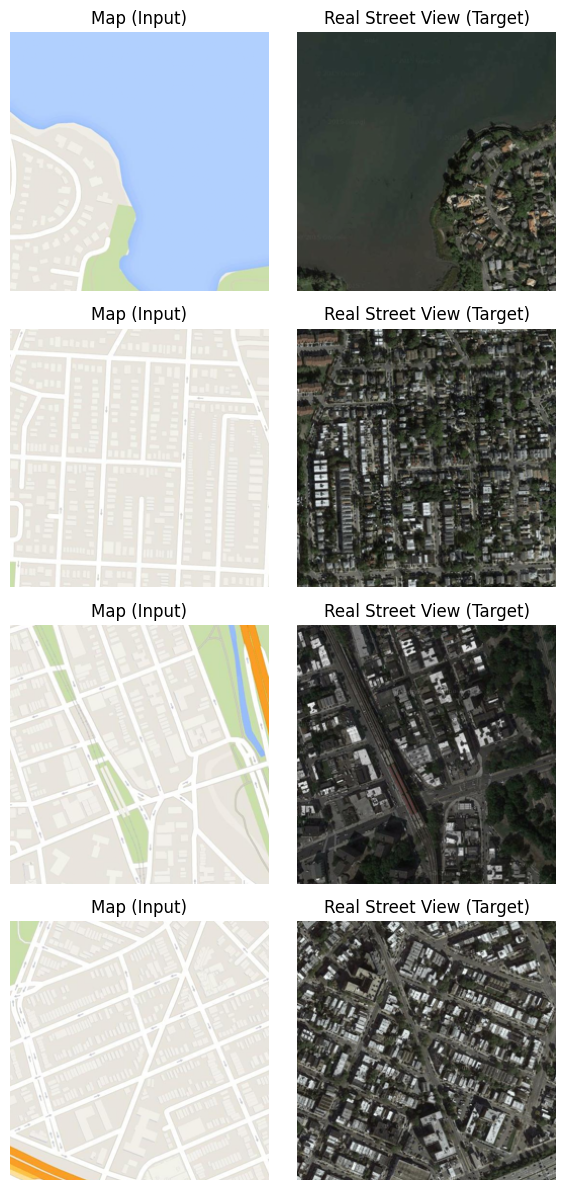

In [58]:
fig, axes = plt.subplots(4, 2, figsize=(6, 12))

for i, (street, map_) in enumerate(train_dl):
    inp = map_ * 0.5 + 0.5
    tgt = street * 0.5 + 0.5
    axes[i,0].imshow(inp[0].permute(1,2,0)); axes[i,0].set_title("Map (Input)")
    axes[i,1].imshow(tgt[0].permute(1,2,0)); axes[i,1].set_title("Street View (Target)")

    for ax in axes[i]:
        ax.axis("off")

plt.tight_layout()
plt.show()


## Discriminator Network

In [59]:
class Pix2PixDiscriminator(nn.Module):
    def __init__(self, in_channels=3, base_features=64):
        super().__init__()
        # Since we concatwnate two images, the first conv sees in_channels*2
        self.model = nn.Sequential(
        # → (in_channels*2) x 256 x 256
        nn.Conv2d(in_channels * 2, base_features, kernel_size=4, stride=2, padding=1, bias=False),
        nn.InstanceNorm2d(base_features),
        nn.LeakyReLU(0.2, inplace=True),
        # → base_features x 128 x 128

        nn.Conv2d(base_features, base_features*2, kernel_size=4, stride=2, padding=1, bias=False),
        nn.InstanceNorm2d(base_features*2),
        nn.LeakyReLU(0.2, inplace=True),
        # → (base_features*2) x 64 x 64

        nn.Conv2d(base_features*2, base_features*4, kernel_size=4, stride=2, padding=1, bias=False),
        nn.InstanceNorm2d(base_features*4),
        nn.LeakyReLU(0.2, inplace=True),
        # → (base_features*4) x 32 x 32

        nn.ZeroPad2d(1),  
        # → (base_features*4) x 34 x 34

        nn.Conv2d(base_features*4, base_features*8, kernel_size=4, stride=1, padding=1, bias=False),
        nn.InstanceNorm2d(base_features*8),
        nn.LeakyReLU(0.2, inplace=True),
        # → (base_features*8) x 32 x 32

        nn.ZeroPad2d(1),  
        # → (base_features*8) x 34 x 34

        # final “patch” conv; produces a 31×31 score map
        nn.Conv2d(base_features*8, 1, kernel_size=4, stride=1, padding=1, bias=False),
        # → 1 x 31 x 31
        )

    def forward(self, real_input, real_target):
        x = torch.cat([real_input, real_target], dim = 1)  
        return self.model(x)

## Generator Network

In [60]:
class Pix2PixGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=64):
        super().__init__()
        # --- ENCODER (downsampling) ---
        # 256→128
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # 128→64
        self.enc2 = nn.Sequential(
            nn.Conv2d(features, features*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(features*2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # 64→32
        self.enc3 = nn.Sequential(
            nn.Conv2d(features*2, features*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(features*4),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # 32→16
        self.enc4 = nn.Sequential(
            nn.Conv2d(features*4, features*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(features*8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # 16→8
        self.enc5 = nn.Sequential(
            nn.Conv2d(features*8, features*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(features*8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # 8→4
        self.enc6 = nn.Sequential(
            nn.Conv2d(features*8, features*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(features*8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # 4→2
        self.enc7 = nn.Sequential(
            nn.Conv2d(features*8, features*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(features*8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # 2→1  (bottleneck)
        self.enc8 = nn.Sequential(
            nn.Conv2d(features*8, features*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # --- DECODER (upsampling) ---
        # 1→2
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(features*8, features*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(features*8),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True)
        )
        # 2→4 (cat → 16 channels in)
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(features*8*2, features*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(features*8),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True)
        )
        # 4→8
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(features*8*2, features*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(features*8),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True)
        )
        # 8→16
        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(features*8*2, features*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(features*8),
            nn.ReLU(inplace=True)
        )
        # 16→32 (cat 16+16→32 channels)
        self.dec5 = nn.Sequential(
            nn.ConvTranspose2d(features*8*2, features*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(features*4),
            nn.ReLU(inplace=True)
        )
        # 32→64
        self.dec6 = nn.Sequential(
            nn.ConvTranspose2d(features*4*2, features*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(features*2),
            nn.ReLU(inplace=True)
        )
        # 64→128
        self.dec7 = nn.Sequential(
            nn.ConvTranspose2d(features*2*2, features,   kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(features),
            nn.ReLU(inplace=True)
        )

        # final 128→256 & 3 channels
        self.final = nn.Sequential(
            nn.ConvTranspose2d(features*2, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        e1 = self.enc1(x)   # 256→128
        e2 = self.enc2(e1)  # 128→64
        e3 = self.enc3(e2)  # 64→32
        e4 = self.enc4(e3)  # 32→16
        e5 = self.enc5(e4)  # 16→8
        e6 = self.enc6(e5)  # 8→4
        e7 = self.enc7(e6)  # 4→2
        e8 = self.enc8(e7)  # 2→1  (bottleneck)

        # --- decode & concat skips ---
        d1 = self.dec1(e8); d1 = torch.cat([d1, e7], dim=1)  # 1→2
        d2 = self.dec2(d1); d2 = torch.cat([d2, e6], dim=1)  # 2→4
        d3 = self.dec3(d2); d3 = torch.cat([d3, e5], dim=1)  # 4→8
        d4 = self.dec4(d3); d4 = torch.cat([d4, e4], dim=1)  # 8→16
        d5 = self.dec5(d4); d5 = torch.cat([d5, e3], dim=1)  # 16→32
        d6 = self.dec6(d5); d6 = torch.cat([d6, e2], dim=1)  # 32→64
        d7 = self.dec7(d6); d7 = torch.cat([d7, e1], dim=1)  # 64→128

        return self.final(d7) # → 256×256×3

## Discriminator Training

In [61]:
def train_discriminator(discriminator, generator, real_images, map_images, opt_d):
    discriminator.train()
    
    # Clear discriminator gradients
    opt_d.zero_grad()

    # ——— Real pairs ———
    # D(map, real) should predict “real” → target=1
    real_preds = discriminator(real_images, map_images)
    real_targets = torch.ones_like(real_preds)
    real_loss = F.binary_cross_entropy_with_logits(real_preds, real_targets)
    real_score = real_preds.mean().item()

    # ——— Fake pairs ———
    # Generate fake images
    # G(map) → fake; detach so G’s grad isn’t updated here
    fake_images = generator(real_images).detach()
    fake_preds = discriminator(real_images, fake_images)
    fake_targets = torch.zeros_like(fake_preds)
    fake_loss    = F.binary_cross_entropy_with_logits(fake_preds, fake_targets)
    fake_score   = fake_preds.mean().item()


    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    
    return loss.item(), real_score, fake_score

## Generator Training

In [62]:
def train_generator(discriminator, generator, real_images, map_images, opt_g, lambda_L1 = 10):
    generator.train()
    
    # Clear generator gradients
    opt_g.zero_grad()

    # 1) Adversarial loss
    # Generate fake images
    fake_images = generator(real_images)

    # Try to fool the discriminator
    preds = discriminator(real_images, fake_images)
    targets = torch.ones_like(preds)
    adv_loss = F.binary_cross_entropy_with_logits(preds, targets)

    # 2) L1 reconstruction loss
    l1_loss = F.l1_loss(fake_images, map_images)

    total_loss = adv_loss + (lambda_L1 * l1_loss)

    # Update generator weights
    total_loss.backward()
    opt_g.step()

    return total_loss.item(), adv_loss.item(), l1_loss.item()

In [63]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

## Saving Generated Samples

In [64]:
def save_samples(idx, street_batch, generator, denorm, show=True):
    generator.eval()
    with torch.no_grad():
        fake = generator(street_batch)         

    # Denormalize into [0,1] for saving/viewing
    fake = denorm(fake)

    fname = f'generated-images-{index:04d}.png'
    save_image(fake, os.path.join(sample_dir, fname), nrow=8)
    print('Saving', fname)

    if show:
        grid = make_grid(fake.cpu(), nrow=8)   # shape (3, H, W)
        plt.figure(figsize=(8,8))
        plt.axis('off')
        plt.imshow(grid.permute(1,2,0)) # H×W×3
        plt.show()

## Full Training Loop

In [65]:
# Denormalize from [-1,1] back to [0,1]
def denorm(imgs):
    return imgs * 0.5 + 0.5

In [66]:
def fit(
    discriminator: nn.Module,
    generator:     nn.Module,
    train_dl,
    fixed_streets,        # a batch of streets images, e.g. next(iter(val_dl))
    denorm,               # function mapping [-1,1]→[0,1]
    device = None,
    epochs = 200,
    lr = 2e-4,
    start_idx = 1
):

    torch.manual_seed(42)
    np.random.seed(42)
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    # ── LR schedulers: decay LR by 0.5 every 25 epochs ──
    from torch.optim.lr_scheduler import StepLR
    sched_d = StepLR(opt_d, step_size=25, gamma=0.5)
    sched_g = StepLR(opt_g, step_size=25, gamma=0.5)


    for epoch in range(start_idx, start_idx + epochs):
        sum_d = sum_g = 0.0
        sum_real_s = sum_fake_s = 0.0
        n = 0

        for street_imgs, map_imgs in tqdm(train_dl, desc=f"Epoch {epoch}/{start_idx+epochs-1}"):
            # — Train D —
            d_loss, real_s, fake_s = train_discriminator(
                discriminator, generator,
                street_imgs, map_imgs,
                opt_d
            )

            # — Train G —
            g_loss, adv_loss, l1_loss = train_generator(
                discriminator, generator,
                street_imgs, map_imgs,
                opt_g
            )

            sum_d       += d_loss
            sum_g       += g_loss
            sum_real_s  += real_s
            sum_fake_s  += fake_s
            n           += 1

        # Averages
        avg_d = sum_d / n
        avg_g = sum_g / n
        avg_real = sum_real_s / n
        avg_fake = sum_fake_s / n

        # Record losses & scores
        losses_d.append(avg_d)
        losses_g.append(avg_g)
        real_scores.append(avg_real)
        fake_scores.append(avg_fake)

        # Log losses & scores (last batch)
        print(
            f"Epoch [{epoch}]  "
            f"loss_g: {avg_g:.4f}, loss_d: {avg_d:.4f}, "
            f"real_score: {avg_real:.4f}, fake_score: {avg_fake:.4f}"
        )

        # Save generated images
        save_samples(epoch, fixed_streets, generator, denorm)

        # Step the schedulers each epoch
        sched_d.step()
        sched_g.step()

        if epoch % 5 == 0:
            torch.save(generator.state_dict(), f"checkpoint_gen_epoch{epoch}.pth")

    return losses_g, losses_d, real_scores, fake_scores

In [67]:
discriminator = Pix2PixDiscriminator()
generator     = Pix2PixGenerator()
fixed_streets, _ = next(iter(train_dl))
lr = 0.0002
epochs = 50

history = fit(
    discriminator=discriminator,
    generator=generator,
    train_dl=train_dl,
    fixed_maps=fixed_maps,
    denorm=denorm,
    device=None,  
    epochs=100,
    lr=2e-4,
    start_idx=1
)

losses_g, losses_d, real_scores, fake_scores = history

Epoch 1/100: 100%|██████████| 1096/1096 [12:03<00:00,  1.52it/s]


Epoch [1]  loss_g: 29.8490, loss_d: 0.0991, real_score: 5.6729, fake_score: -5.6692
Saving generated-images-0001.png


Epoch 2/100: 100%|██████████| 1096/1096 [11:51<00:00,  1.54it/s]


Epoch [2]  loss_g: 26.0256, loss_d: 0.3775, real_score: 3.9738, fake_score: -3.3306
Saving generated-images-0002.png


Epoch 3/100: 100%|██████████| 1096/1096 [12:12<00:00,  1.50it/s]


Epoch [3]  loss_g: 27.5332, loss_d: 0.4165, real_score: 3.7264, fake_score: -3.3702
Saving generated-images-0003.png


Epoch 4/100: 100%|██████████| 1096/1096 [11:44<00:00,  1.56it/s]


Epoch [4]  loss_g: 28.1233, loss_d: 0.4338, real_score: 3.6152, fake_score: -3.2590
Saving generated-images-0004.png


Epoch 5/100: 100%|██████████| 1096/1096 [11:58<00:00,  1.52it/s]


Epoch [5]  loss_g: 28.7712, loss_d: 0.2715, real_score: 4.5840, fake_score: -4.6458
Saving generated-images-0005.png


Epoch 6/100: 100%|██████████| 1096/1096 [12:55<00:00,  1.41it/s]


Epoch [6]  loss_g: 29.2467, loss_d: 0.2242, real_score: 4.9989, fake_score: -5.0608
Saving generated-images-0006.png


Epoch 7/100: 100%|██████████| 1096/1096 [13:07<00:00,  1.39it/s]


Epoch [7]  loss_g: 30.0679, loss_d: 0.1899, real_score: 5.4657, fake_score: -6.0297
Saving generated-images-0007.png


Epoch 8/100: 100%|██████████| 1096/1096 [12:44<00:00,  1.43it/s]


Epoch [8]  loss_g: 29.8922, loss_d: 0.2226, real_score: 5.4128, fake_score: -5.9696
Saving generated-images-0008.png


Epoch 9/100: 100%|██████████| 1096/1096 [13:12<00:00,  1.38it/s]


Epoch [9]  loss_g: 29.8003, loss_d: 0.1720, real_score: 5.8266, fake_score: -6.4507
Saving generated-images-0009.png


Epoch 10/100: 100%|██████████| 1096/1096 [13:46<00:00,  1.33it/s]


Epoch [10]  loss_g: 29.9981, loss_d: 0.1764, real_score: 5.8811, fake_score: -6.4445
Saving generated-images-0010.png


Epoch 11/100: 100%|██████████| 1096/1096 [13:36<00:00,  1.34it/s]


Epoch [11]  loss_g: 29.2692, loss_d: 0.1489, real_score: 6.5164, fake_score: -6.5867
Saving generated-images-0011.png


Epoch 12/100: 100%|██████████| 1096/1096 [13:11<00:00,  1.38it/s]


Epoch [12]  loss_g: 30.3245, loss_d: 0.1858, real_score: 6.0728, fake_score: -6.6632
Saving generated-images-0012.png


Epoch 13/100: 100%|██████████| 1096/1096 [12:30<00:00,  1.46it/s]


Epoch [13]  loss_g: 30.0850, loss_d: 0.1336, real_score: 6.2779, fake_score: -7.1456
Saving generated-images-0013.png


Epoch 14/100: 100%|██████████| 1096/1096 [13:13<00:00,  1.38it/s]


Epoch [14]  loss_g: 30.0666, loss_d: 0.1220, real_score: 6.8347, fake_score: -7.3291
Saving generated-images-0014.png


Epoch 15/100: 100%|██████████| 1096/1096 [19:46<00:00,  1.08s/it]


Epoch [15]  loss_g: 30.8953, loss_d: 0.1353, real_score: 6.0252, fake_score: -7.5729
Saving generated-images-0015.png


Epoch 16/100: 100%|██████████| 1096/1096 [20:32<00:00,  1.12s/it]


Epoch [16]  loss_g: 30.9175, loss_d: 0.1314, real_score: 6.3725, fake_score: -7.2754
Saving generated-images-0016.png


Epoch 17/100: 100%|██████████| 1096/1096 [20:14<00:00,  1.11s/it]


Epoch [17]  loss_g: 30.5158, loss_d: 0.1616, real_score: 6.5365, fake_score: -7.3340
Saving generated-images-0017.png


Epoch 18/100: 100%|██████████| 1096/1096 [20:19<00:00,  1.11s/it]


Epoch [18]  loss_g: 30.2815, loss_d: 0.1856, real_score: 6.4697, fake_score: -6.7207
Saving generated-images-0018.png


Epoch 19/100: 100%|██████████| 1096/1096 [21:06<00:00,  1.16s/it]


Epoch [19]  loss_g: 30.6198, loss_d: 0.1689, real_score: 6.2142, fake_score: -6.9872
Saving generated-images-0019.png


Epoch 20/100: 100%|██████████| 1096/1096 [20:14<00:00,  1.11s/it]


Epoch [20]  loss_g: 30.9115, loss_d: 0.1477, real_score: 6.6553, fake_score: -7.5342
Saving generated-images-0020.png


Epoch 21/100: 100%|██████████| 1096/1096 [21:14<00:00,  1.16s/it]


Epoch [21]  loss_g: 30.9575, loss_d: 0.1776, real_score: 6.1704, fake_score: -6.7613
Saving generated-images-0021.png


Epoch 22/100: 100%|██████████| 1096/1096 [19:23<00:00,  1.06s/it]


Epoch [22]  loss_g: 31.8867, loss_d: 0.1221, real_score: 6.1583, fake_score: -7.2727
Saving generated-images-0022.png


Epoch 23/100: 100%|██████████| 1096/1096 [22:35<00:00,  1.24s/it]


Epoch [23]  loss_g: 30.9717, loss_d: 0.2282, real_score: 5.9322, fake_score: -6.3646
Saving generated-images-0023.png


Epoch 24/100: 100%|██████████| 1096/1096 [21:59<00:00,  1.20s/it]


Epoch [24]  loss_g: 31.0913, loss_d: 0.1497, real_score: 6.5124, fake_score: -7.0384
Saving generated-images-0024.png


Epoch 25/100: 100%|██████████| 1096/1096 [22:06<00:00,  1.21s/it]


Epoch [25]  loss_g: 31.8394, loss_d: 0.1697, real_score: 6.7827, fake_score: -7.6868
Saving generated-images-0025.png


Epoch 26/100: 100%|██████████| 1096/1096 [21:56<00:00,  1.20s/it]


Epoch [26]  loss_g: 32.0043, loss_d: 0.1305, real_score: 6.8329, fake_score: -7.7034
Saving generated-images-0026.png


Epoch 27/100: 100%|██████████| 1096/1096 [22:00<00:00,  1.21s/it]


Epoch [27]  loss_g: 31.6671, loss_d: 0.1755, real_score: 7.0286, fake_score: -7.5387
Saving generated-images-0027.png


Epoch 28/100: 100%|██████████| 1096/1096 [22:29<00:00,  1.23s/it]


Epoch [28]  loss_g: 31.8314, loss_d: 0.1534, real_score: 7.0947, fake_score: -7.8593
Saving generated-images-0028.png


Epoch 29/100: 100%|██████████| 1096/1096 [23:12<00:00,  1.27s/it]


Epoch [29]  loss_g: 30.2524, loss_d: 0.2415, real_score: 6.2730, fake_score: -5.5725
Saving generated-images-0029.png


Epoch 30/100: 100%|██████████| 1096/1096 [20:46<00:00,  1.14s/it]


Epoch [30]  loss_g: 30.5781, loss_d: 0.2214, real_score: 5.9352, fake_score: -5.9203
Saving generated-images-0030.png


Epoch 31/100: 100%|██████████| 1096/1096 [23:06<00:00,  1.27s/it]


Epoch [31]  loss_g: 29.9980, loss_d: 0.2584, real_score: 5.7389, fake_score: -5.3428
Saving generated-images-0031.png


Epoch 32/100: 100%|██████████| 1096/1096 [24:07<00:00,  1.32s/it]


Epoch [32]  loss_g: 30.3695, loss_d: 0.1966, real_score: 6.0557, fake_score: -5.7605
Saving generated-images-0032.png


Epoch 33/100: 100%|██████████| 1096/1096 [27:45<00:00,  1.52s/it]


Epoch [33]  loss_g: 30.3794, loss_d: 0.2246, real_score: 6.3524, fake_score: -5.7623
Saving generated-images-0033.png


Epoch 34/100: 100%|██████████| 1096/1096 [41:53<00:00,  2.29s/it]


Epoch [34]  loss_g: 29.9734, loss_d: 0.2465, real_score: 5.9105, fake_score: -5.3175
Saving generated-images-0034.png


Epoch 35/100: 100%|██████████| 1096/1096 [40:37<00:00,  2.22s/it]


Epoch [35]  loss_g: 30.0021, loss_d: 0.2559, real_score: 5.7444, fake_score: -5.2009
Saving generated-images-0035.png


Epoch 36/100: 100%|██████████| 1096/1096 [40:21<00:00,  2.21s/it]


Epoch [36]  loss_g: 30.2436, loss_d: 0.2422, real_score: 5.9897, fake_score: -5.1858
Saving generated-images-0036.png


Epoch 37/100: 100%|██████████| 1096/1096 [40:29<00:00,  2.22s/it]


Epoch [37]  loss_g: 29.4892, loss_d: 0.2539, real_score: 6.1061, fake_score: -4.7498
Saving generated-images-0037.png


Epoch 38/100: 100%|██████████| 1096/1096 [39:41<00:00,  2.17s/it]


Epoch [38]  loss_g: 29.6339, loss_d: 0.2662, real_score: 6.1720, fake_score: -4.8083
Saving generated-images-0038.png


Epoch 39/100: 100%|██████████| 1096/1096 [40:21<00:00,  2.21s/it]


Epoch [39]  loss_g: 29.4788, loss_d: 0.2510, real_score: 6.2682, fake_score: -4.6789
Saving generated-images-0039.png


Epoch 40/100: 100%|██████████| 1096/1096 [41:18<00:00,  2.26s/it]


Epoch [40]  loss_g: 29.6589, loss_d: 0.2549, real_score: 6.0042, fake_score: -4.5507
Saving generated-images-0040.png


Epoch 41/100: 100%|██████████| 1096/1096 [41:57<00:00,  2.30s/it]


Epoch [41]  loss_g: 29.9813, loss_d: 0.2509, real_score: 6.0810, fake_score: -4.6236
Saving generated-images-0041.png


Epoch 42/100: 100%|██████████| 1096/1096 [41:57<00:00,  2.30s/it]


Epoch [42]  loss_g: 30.1351, loss_d: 0.2191, real_score: 6.3436, fake_score: -4.9419
Saving generated-images-0042.png


Epoch 43/100: 100%|██████████| 1096/1096 [41:22<00:00,  2.26s/it]


Epoch [43]  loss_g: 30.2446, loss_d: 0.2189, real_score: 6.3242, fake_score: -4.9537
Saving generated-images-0043.png


Epoch 44/100: 100%|██████████| 1096/1096 [41:51<00:00,  2.29s/it]


Epoch [44]  loss_g: 30.2095, loss_d: 0.2516, real_score: 6.0021, fake_score: -4.7050
Saving generated-images-0044.png


Epoch 45/100: 100%|██████████| 1096/1096 [40:29<00:00,  2.22s/it]


Epoch [45]  loss_g: 30.1899, loss_d: 0.1891, real_score: 6.7957, fake_score: -5.1588
Saving generated-images-0045.png


Epoch 46/100: 100%|██████████| 1096/1096 [40:41<00:00,  2.23s/it]


Epoch [46]  loss_g: 30.6472, loss_d: 0.2195, real_score: 6.2884, fake_score: -4.9070
Saving generated-images-0046.png


Epoch 47/100: 100%|██████████| 1096/1096 [40:39<00:00,  2.23s/it]


Epoch [47]  loss_g: 30.4392, loss_d: 0.2258, real_score: 6.3839, fake_score: -4.9442
Saving generated-images-0047.png


Epoch 48/100: 100%|██████████| 1096/1096 [27:12<00:00,  1.49s/it]


Epoch [48]  loss_g: 30.4794, loss_d: 0.2184, real_score: 6.4067, fake_score: -4.8316
Saving generated-images-0048.png


Epoch 49/100: 100%|██████████| 1096/1096 [20:01<00:00,  1.10s/it]


Epoch [49]  loss_g: 30.6216, loss_d: 0.2236, real_score: 6.6559, fake_score: -4.8888
Saving generated-images-0049.png


Epoch 50/100: 100%|██████████| 1096/1096 [20:03<00:00,  1.10s/it]


Epoch [50]  loss_g: 30.6637, loss_d: 0.2070, real_score: 6.8230, fake_score: -5.2255
Saving generated-images-0050.png


Epoch 51/100: 100%|██████████| 1096/1096 [20:08<00:00,  1.10s/it]


Epoch [51]  loss_g: 31.0337, loss_d: 0.2232, real_score: 6.8136, fake_score: -5.2717
Saving generated-images-0051.png


Epoch 52/100:  71%|███████   | 778/1096 [1:22:13<40:43,  7.68s/it]  

## Checkpointing


In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

Here's how the generated images look, after the 1st, 5th, 10th, and 50th epochs of training.

In [ ]:
Image('./generated/generated-images-0001.png')

In [ ]:
Image('./generated/generated-images-0005.png')

In [ ]:
Image('./generated/generated-images-0010.png')

In [ ]:
Image('./generated/generated-images-0050.png')

## Plotting Loss of Generator & Discriminator

In [ ]:
epochs_range = list(range(1, len(losses_d) + 1))

In [ ]:
plt.clf()
plt.plot(epochs_range, losses_d, label="Discriminator")
plt.plot(epochs_range, losses_g, label="Generator")
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

## Plotting Real & Fake Scores

In [ ]:
plt.clf()
plt.plot(epochs_range, real_scores, label="Real Score")
plt.plot(epochs_range, fake_scores, label="Fake Score")
plt.xlabel("Epoch")
plt.ylabel("Scores")
plt.title("Real vs Fake Scores per Epoch")
plt.legend()
plt.grid(True)
plt.show()

## Generating New Images

In [ ]:
# Building a validation loader
val_ds  = Pix2PixDataset('./data/maps', mode='val')
val_dl  = DataLoader(val_ds, batch_size=5, shuffle=True, num_workers=0, pin_memory=True)

In [ ]:
generator = Pix2PixGenerator()
generator.load_state_dict(torch.load('G.pth'))
generator.eval()

# Sampling from val_dl
maps_batch, _ = next(iter(val_dl))
fake_batch = generator(maps_batch)
fake_batch = denorm(fake_batch)

In [ ]:
# Display Images
grid = make_grid(fake_batch, nrow=5).permute(1,2,0).squeeze()
plt.figure(figsize=(25,3), dpi=100)
plt.axis('off')
plt.imshow(grid, interpolation='nearest')
plt.show()

## User Interface

In [ ]:
# Wrapper to run your model end-to-end
def translate(real_img: PIL.Image.Image) -> PIL.Image.Image:
    img = full_augment(real_img)
    street = to_tensor_norm(img.crop((0,0,256,256)))
    x = data_transform(real_img).unsqueeze(0)  # 1×3×256×256
    with torch.no_grad():
        fake = generator(x)   # 1×3×256×256
    fake = denorm(fake[0]).clamp(0,1)   # back to [0,1]
    return ToPILImage()(fake)  # PIL for display

In [ ]:
iface = gr.Interface(
    fn=translate,
    inputs=gr.Image(type="pil", label="Input Image"),
    outputs=gr.Image(type="pil", label="Generated Map"),
    title="StreetViewGAN",
    description="Upload a street view image; get the generated map."
)

In [ ]:
# Launch
iface.launch()